# Insights from the UK PSC register

*Author: Maria Jofre <br>
Date: 01/04/2025*

### Introduction

This notebook supports the collaborative research between Maria Jofre (Open Ownership) and Andres Knobel (Tax Justice Network), as presented in the submission "Insights from the UK People with Significant Control (PSC) Register."

The analysis draws on structured beneficial ownership data published by Open Ownership using the Beneficial Ownership Data Standard (BODS), available through the [Beneficial Ownership Data Analysis Tools](https://bods.openownership.org/source/UK_PSC/). The accompanying code is also available in the corresponding [GitHub repository](https://github.com/openownership/bodsanalysis/blob/main/Insights_UK_PSC_BODS-02.ipynb).

The goal is to explore the ownership and control structures reported in the UK PSC register, assess data quality, and generate insights to support red-flagging and inform policy recommendations.

---
## Set up

In [1]:
# First install required libraries
!pip install networkx==3.4.2

# Then import libraries and set up the environment
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import qbods
import os

#importing bods data from OO website
qbods.getBodsData('https://oo-bodsdata.s3.amazonaws.com/data/UK_PSC/csv.zip')

# Set Seaborn plot style and palette
sns.set_context('notebook')
sns.set_style('ticks')
crayon = ['#4E79A7','#76B7B2']
sns.set_palette(crayon)

# Create 'Images' folder if it doesn't exist
os.makedirs('Images', exist_ok=True)

3308750K .......... .......... .......... .......... .......... 98% 69.5M 1s
3308800K .......... .......... .......... .......... .......... 98% 58.5M 1s
3308850K .......... .......... .......... .......... .......... 98% 70.8M 1s
3308900K .......... .......... .......... .......... .......... 98% 70.3M 1s
3308950K .......... .......... .......... .......... .......... 98% 57.8M 1s
3309000K .......... .......... .......... .......... .......... 98% 58.8M 1s
3309050K .......... .......... .......... .......... .......... 98% 68.3M 1s
3309100K .......... .......... .......... .......... .......... 98% 61.1M 1s
3309150K .......... .......... .......... .......... .......... 98% 68.4M 1s
3309200K .......... .......... .......... .......... .......... 98% 12.2M 1s
3309250K .......... .......... .......... .......... .......... 98% 68.3M 1s
3309300K .......... .......... .......... .......... .......... 98% 67.4M 1s
3309350K .......... .......... .......... .......... .......... 98% 67.5M 1s

---
## Data processing

In [2]:
# Read entity-related tables
es = pd.read_csv(
    'csv/entity_statement.csv', 
    usecols=['_link', 'statementID', 'name', 'dissolutionDate'],
    dtype={'_link': str, 'statementID': str}
)
ei = pd.read_csv(
    'csv/entity_identifiers.csv', 
    usecols=['_link_entity_statement', 'scheme', 'id'], 
    dtype={'_link_entity_statement': str, 'id': str}
)

# Merge entity-related dataframes
merged_entity = pd.merge(es, ei, left_on='_link', right_on='_link_entity_statement', how='left')

# Rename columns
merged_entity = merged_entity.rename(columns={
    'id': 'entity_ID',
    'statementID': 'entity_statementID',
    'name': 'entity_name'
})

# Filter entities for only those with registration numbers from Companies House
merged_entity = merged_entity[merged_entity['scheme'] == 'GB-COH'].reset_index(drop=True)
merged_entity.drop(columns=['_link','scheme'], inplace=True)

# Calculate the number of unique values
n_entity_statementID_disambiguation = merged_entity['entity_statementID'].nunique()
n_entity_ID_disambiguation = merged_entity['entity_ID'].nunique()

# Filter inactive/dissolved entities
merged_entity = merged_entity[merged_entity['dissolutionDate'].isna()].reset_index(drop=True)
merged_entity.drop(columns=['dissolutionDate'], inplace=True)

# Calculate the number of unique values
n_entity_ID_active = merged_entity['entity_ID'].nunique()

# Reorder columns
merged_entity = merged_entity[['entity_ID', 'entity_statementID', 'entity_name']]

# Create a set of valid entity statement IDs for filtering
valid_entity_statements = set(merged_entity['entity_statementID'])

# Clean up memory by deleting unnecessary dataframes
del es, ei

# Compute the disambiguation reduction percentage
n_entity_disambiguation_reduction = 100 - (n_entity_ID_disambiguation / n_entity_statementID_disambiguation) * 100

# Display the results
print(f'The entity disambiguation reduction is {int(n_entity_disambiguation_reduction)}%')

# Compute the inactive reduction percentage
n_entity_inactive_reduction = 100 - (n_entity_ID_active / n_entity_ID_disambiguation) * 100

# Display the results
print(f'The entity inactive reduction is {int(n_entity_inactive_reduction)}%')

The entity disambiguation reduction is 10%
The entity inactive reduction is 32%


In [3]:
# Read person-related tables
ps = pd.read_csv(
    'csv/person_statement.csv', 
    usecols=['_link', 'statementID'], 
    dtype={'_link': str, 'statementID': str}
)
pi = pd.read_csv(
    'csv/person_identifiers.csv', 
    usecols=['_link_person_statement', 'id'], 
    dtype={'_link_person_statement': str, 'id': str}
)
pn = pd.read_csv(
    'csv/person_names.csv', 
    usecols=['_link_person_statement', 'fullName'], 
    dtype={'_link_person_statement': str}
)

# Merge person-related dataframes
merged_person = pd.merge(ps, pi, left_on='_link', right_on='_link_person_statement', how='left')
merged_person.drop(columns=['_link_person_statement'], inplace=True)
merged_person = pd.merge(merged_person, pn, left_on='_link', right_on='_link_person_statement', how='left')

# Rename and reorder columns
merged_person = merged_person.rename(columns={
    'id': 'person_ID',
    'statementID': 'person_statementID',
    'fullName': 'person_fullName'
})[['person_ID', 'person_statementID', 'person_fullName']]

# Create a set of valid person statement IDs for filtering
valid_person_statements = set(merged_person['person_statementID'])

# Clean up memory by deleting unnecessary dataframes
del ps, pi

# Calculate the number of unique values in both columns
n_unique_person_statementID = merged_person['person_statementID'].nunique()
n_unique_person_ID = merged_person['person_ID'].nunique()

# Compute the reduction percentage
n_person_reduction_percentage = 100 - (n_unique_person_ID / n_unique_person_statementID) * 100

# Display the results
print(f'The person disambiguation reduction is {int(n_person_reduction_percentage)}%')

The person disambiguation reduction is 5%


In [4]:
# Read and merge ownership or control statement-related tables
ooc = pd.read_csv(
    'csv/ooc_statement.csv', 
    usecols=['_link', 'statementID', 'interestedParty_describedByPersonStatement', 'interestedParty_describedByEntityStatement', 'subject_describedByEntityStatement'], 
    dtype={
        '_link': str,
        'statementID': str,
        'interestedParty_describedByPersonStatement': str,
        'interestedParty_describedByEntityStatement': str,
        'subject_describedByEntityStatement': str
    }
)
ooci = pd.read_csv(
    'csv/ooc_interests.csv',
    usecols=['_link_ooc_statement', 'type', 'share_minimum', 'share_maximum', 'endDate'],
    dtype={'_link_ooc_statement': str}
)

# Merge ooc tables
processed_ooc = pd.merge(ooc, ooci, left_on='_link', right_on='_link_ooc_statement', how='left')
n_all_ooc_interests = len(processed_ooc)

# Filter out ended relations
processed_ooc = processed_ooc[processed_ooc['endDate'].isna()].reset_index(drop=True)
processed_ooc = processed_ooc.rename(columns={
    'statementID': 'ooc_statementID',
    'type': 'interest_type'
})[['ooc_statementID', 'interestedParty_describedByPersonStatement', 'interestedParty_describedByEntityStatement', 'subject_describedByEntityStatement', 'interest_type', 'share_minimum', 'share_maximum']].reset_index(drop=True)

# Filter ownership/control relations using valid person and entity statements
merged_ooc = processed_ooc[
    (
        (processed_ooc['interestedParty_describedByPersonStatement'].notna() & 
         processed_ooc['interestedParty_describedByPersonStatement'].isin(valid_person_statements)) | 
        (processed_ooc['interestedParty_describedByEntityStatement'].notna() & 
         processed_ooc['interestedParty_describedByEntityStatement'].isin(valid_entity_statements))
    ) &
    (
        processed_ooc['subject_describedByEntityStatement'].notna() & 
        processed_ooc['subject_describedByEntityStatement'].isin(valid_entity_statements)
    )
].drop_duplicates().reset_index(drop=True)
n_active_ooc_interests = len(processed_ooc)

# Clean up memory by deleting unnecessary dataframes
del ooc, ooci, processed_ooc

# Compute the reduction percentage
n_ooc_reduction_percentage = 100 - (n_active_ooc_interests / n_all_ooc_interests) * 100

# Display the results
print(f'The reduction of ended relationships is {int(n_ooc_reduction_percentage)}%')

The reduction of ended relationships is 11%


In [5]:
# Process related columns for share range and interest type
merged_ooc['threshold_range'] = merged_ooc.apply(
    lambda row: f"{int(row['share_minimum'])}-{int(row['share_maximum'])}" 
    if pd.notnull(row['share_minimum']) and pd.notnull(row['share_maximum']) 
    else None, 
    axis=1
)
merged_ooc['interest_type'] = merged_ooc['interest_type'].str.replace('-', ' ').str.capitalize()
merged_ooc.drop(columns=['share_minimum','share_maximum'], inplace=True)

# Merge to add interestedParty_describedByPersonID
merged_ooc = pd.merge(
    merged_ooc,
    merged_person[['person_statementID', 'person_ID']],
    left_on='interestedParty_describedByPersonStatement',
    right_on='person_statementID',
    how='left'
).rename(columns={'person_ID': 'interestedParty_describedByPersonID'})

# Drop the redundant column after merge
merged_ooc.drop(columns=['person_statementID'], inplace=True)

# Merge to add interestedParty_describedByEntityID
merged_ooc = pd.merge(
    merged_ooc,
    merged_entity[['entity_statementID', 'entity_ID']],
    left_on='interestedParty_describedByEntityStatement',
    right_on='entity_statementID',
    how='left'
).rename(columns={'entity_ID': 'interestedParty_describedByEntityID'})

# Drop the redundant column after merge
merged_ooc.drop(columns=['entity_statementID'], inplace=True)

# Merge to add subject_describedByEntityID
merged_ooc = pd.merge(
    merged_ooc,
    merged_entity[['entity_statementID', 'entity_ID']],
    left_on='subject_describedByEntityStatement',
    right_on='entity_statementID',
    how='left'
).rename(columns={'entity_ID': 'subject_describedByEntityID'})

# Drop the redundant column after merge
merged_ooc.drop(columns=['entity_statementID'], inplace=True)

# Combine person and entity interested parties into a single column
merged_ooc['interestedParty_describedByID'] = merged_ooc['interestedParty_describedByPersonID'].combine_first(
    merged_ooc['interestedParty_describedByEntityID'])

# Reorder columns to place the new IDs next to their respective statements
column_order = [
    'ooc_statementID',
    'interestedParty_describedByID',
#    'interestedParty_describedByPersonStatement',
    'interestedParty_describedByPersonID',
#    'interestedParty_describedByEntityStatement',
    'interestedParty_describedByEntityID',
#    'subject_describedByEntityStatement',
    'subject_describedByEntityID',
    'interest_type',
    'threshold_range'
]
merged_ooc = merged_ooc[column_order]

# Drop duplicates based on the specified columns
merged_ooc = merged_ooc.drop_duplicates(
    subset=[
        'interestedParty_describedByPersonID',
        'interestedParty_describedByEntityID',
        'subject_describedByEntityID',
        'interest_type'
    ]
).reset_index(drop=True)

# Keep persons with links to entities
merged_person = merged_person[merged_person['person_ID'].isin(merged_ooc['interestedParty_describedByPersonID'])].reset_index(drop=True)

In [6]:
# Extract the list of unique people
people = merged_ooc[merged_ooc['interestedParty_describedByEntityID'].isna()]['interestedParty_describedByPersonID'].drop_duplicates()
people = pd.DataFrame(people, columns=['interestedParty_describedByPersonID'])  # Convert Series to DataFrame
people['attr'] = 'person'

# Create a directed graph from the ownership/control relationships
G = nx.from_pandas_edgelist(
    merged_ooc,
    source='subject_describedByEntityID',
    target='interestedParty_describedByID',
    create_using=nx.DiGraph()
)

# Assign person attributes to nodes in the graph
node_attr = people.set_index('interestedParty_describedByPersonID').to_dict('index')
nx.set_node_attributes(G, node_attr)

# Initialize a list to store the results
results = []

# Analyze each unique entity (whether connected or isolated)
unique_entity_ids = merged_entity['entity_ID'].drop_duplicates().reset_index(drop=True)

for entity in unique_entity_ids:
    if entity in G:  # Check if entity exists in the graph
        # Perform BFS or DFS to determine the ownership structure (layers)
        lengths = nx.single_source_shortest_path_length(G, entity)

        # Calculate number of layers
        num_layers = max(lengths.values()) if len(lengths) > 1 else 0

        # Get all nodes in this ownership structure
        component_nodes = list(nx.descendants(G, entity)) + [entity]

        # Calculate total number of nodes
        num_nodes = len(component_nodes)

        # Count nodes with attribute "person" and calculate number of nodes that are entities
        num_persons = sum(1 for node in component_nodes if G.nodes[node].get("attr") == "person")
        num_entities = num_nodes - num_persons    

        # Append results for this entity
        results.append({
            'subjectID': entity,
            'no_of_layers': num_layers,
            'no_of_nodes': num_nodes,
            'no_of_entities': num_entities,
            'no_of_persons': num_persons
        })
    else:
        # For isolated entities (no owners)
        results.append({
            'subjectID': entity,
            'no_of_layers': 0,
            'no_of_nodes': 1,  # Only the entity itself
            'no_of_entities': 1,  # Just the entity itself
            'no_of_persons': 0,
        }) 

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Clean up memory by deleting unnecessary dataframes
del people, results

***
## 1. UK PSC overview

In [7]:
# Number of entries
len_ps = merged_person['person_ID'].nunique()
len_es = merged_entity['entity_ID'].nunique()
len_ooc = merged_ooc['ooc_statementID'].nunique()
len_ooci = len(merged_ooc)

# Create a DataFrame with the number of entries
data_df = pd.DataFrame({
    'Type': ['People', 'Entities', 'Ownership and control (relationships)', 'Ownership and control (interests)'],
    'Number of entries': [len_ps, len_es, len_ooc, len_ooci]
})
data_df['Number of entries'] = data_df['Number of entries'].apply(lambda x: f"{x:,}")

# Show results
data_df

,Type,Number of entries
0,People,"5,175,041"
1,Entities,"6,061,128"
2,Ownership and control (relationships),"6,494,964"
3,Ownership and control (interests),"14,153,831"


In [8]:
# Count the unique number of relations associated with persons and entities
person_relations_count = merged_ooc[merged_ooc['interestedParty_describedByPersonID'].notna()]['ooc_statementID'].nunique()
entity_relations_count = merged_ooc[merged_ooc['interestedParty_describedByEntityID'].notna()]['ooc_statementID'].nunique()

# Calculate the total number of relations
total_relations = merged_ooc['ooc_statementID'].nunique()

# Calculate the percentages
person_relations_percentage = (person_relations_count / total_relations) * 100
entity_relations_percentage = (entity_relations_count / total_relations) * 100

# Display the results
print(f"Number of relations with persons as interested parties: {person_relations_count:,} ({person_relations_percentage:.0f}% out of {total_relations:,})")
print(f"Number of relations with entities as interested parties: {entity_relations_count:,} ({entity_relations_percentage:.0f}% out of {total_relations:,})")

Number of relations with persons as interested parties: 6,216,182 (96% out of 6,494,964)
Number of relations with entities as interested parties: 278,782 (4% out of 6,494,964)


In [9]:
# Calculate counts and percentages
interest_type_counts = merged_ooc['interest_type'].value_counts()
interest_type_percentages = (interest_type_counts / interest_type_counts.sum()) * 100

# Name the series explicitly
interest_type_counts.name = 'Count'
interest_type_percentages.name = 'Percentage'

# Combine into a DataFrame
interest_type_table = pd.concat([interest_type_counts, interest_type_percentages], axis=1).reset_index()
interest_type_table.columns = ['Interest type', 'Count', 'Percentage']

# Format percentage as string
interest_type_table['Percentage'] = interest_type_table['Percentage'].round(1).astype(str) + '%'

# Display the result
interest_type_table

,Interest type,Count,Percentage
0,Shareholding,5808070,41.0%
1,Voting rights,4508033,31.9%
2,Appointment of board,3200929,22.6%
3,Other influence or control,592867,4.2%
4,Rights to surplus assets on dissolution,43932,0.3%


In [10]:
# Define the desired order for threshold ranges
desired_order = ['25-50', '50-75', '75-100']

# Filter data for 'Shareholding' and calculate frequencies
shareholding_threshold_counts = merged_ooc[merged_ooc['interest_type'] == 'Shareholding']['threshold_range'].value_counts()
shareholding_threshold_percentages = (shareholding_threshold_counts / shareholding_threshold_counts.sum()) * 100

# Combine into a DataFrame for 'Shareholding'
shareholding_table = pd.DataFrame({
    'Count': shareholding_threshold_counts,
    'Percentage': shareholding_threshold_percentages.round(1).astype(str) + '%'
}).reset_index().rename(columns={'threshold_range': 'Shareholding threshold range'})

# Reorder categories according to the desired order
shareholding_table['Shareholding threshold range'] = pd.Categorical(shareholding_table['Shareholding threshold range'], categories=desired_order, ordered=True)
shareholding_table = shareholding_table.sort_values('Shareholding threshold range').reset_index(drop=True)

# Display the results
display(shareholding_table)

# Filter data for 'Voting Rights' and calculate frequencies
voting_rights_threshold_counts = merged_ooc[merged_ooc['interest_type'] == 'Voting rights']['threshold_range'].value_counts()
voting_rights_threshold_percentages = (voting_rights_threshold_counts / voting_rights_threshold_counts.sum()) * 100

# Combine into a DataFrame for 'Voting Rights'
voting_rights_table = pd.DataFrame({
    'Count': voting_rights_threshold_counts,
    'Percentage': voting_rights_threshold_percentages.round(1).astype(str) + '%'
}).reset_index().rename(columns={'threshold_range': 'Voting rights threshold range'})

# Reorder categories according to the desired order
voting_rights_table['Voting rights threshold range'] = pd.Categorical(voting_rights_table['Voting rights threshold range'], categories=desired_order, ordered=True)
voting_rights_table = voting_rights_table.sort_values('Voting rights threshold range').reset_index(drop=True)

# Display the results
display(voting_rights_table)

,Shareholding threshold range,Count,Percentage
0,25-50,2244340,38.6%
1,50-75,283434,4.9%
2,75-100,3280296,56.5%


,Voting rights threshold range,Count,Percentage
0,25-50,1771226,39.3%
1,50-75,197088,4.4%
2,75-100,2539711,56.3%


In [11]:
# Aggregate interest types by ooc_statementID using groupby and join (much faster)
interest_combination_df = (
    merged_ooc.groupby('ooc_statementID')['interest_type']
    .agg(lambda x: ' - '.join(sorted(x.unique())))
    .reset_index()
    .rename(columns={'interest_type': 'interest_combination'})
)

# Merge the aggregated interest combinations back to the main DataFrame
merged_ooc = merged_ooc.merge(
    interest_combination_df, on='ooc_statementID', how='left'
)

# Extract shareholding and voting rights ranges using vectorized operations
merged_ooc['shareholding_range'] = (
    merged_ooc['threshold_range']
    .where(merged_ooc['interest_combination'].str.contains('Shareholding'), None)
)

merged_ooc['voting_rights_range'] = (
    merged_ooc['threshold_range']
    .where(merged_ooc['interest_combination'].str.contains('Voting rights'), None)
)

# Select and keep only the relevant columns and remove duplicates
merged_ooc_aggregate = merged_ooc[
    ['ooc_statementID', 'interest_combination', 'shareholding_range', 'voting_rights_range']
].drop_duplicates(subset='ooc_statementID').reset_index(drop=True)

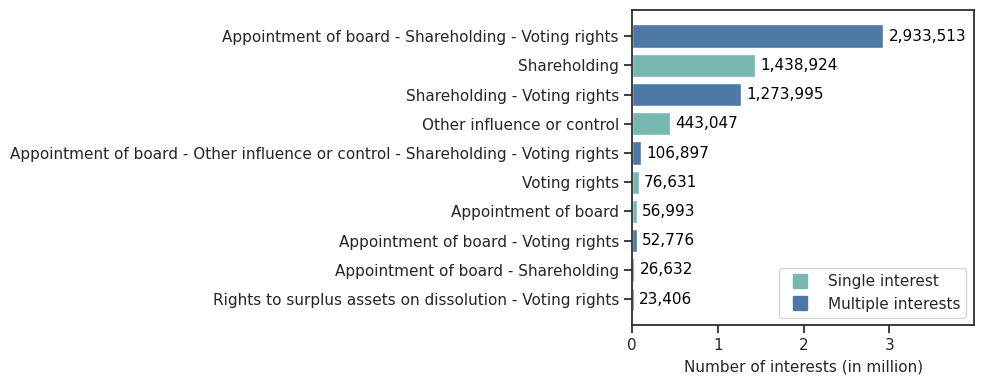

In [12]:
# Get the top 10 most common interest combinations
top_10_combinations = (
    merged_ooc_aggregate['interest_combination']
    .value_counts()
    .head(10)
    .sort_values(ascending=True)
)

# Distinct colours
colors = [
    crayon[0] if ' - ' in combo else crayon[1]
    for combo in top_10_combinations.index
]

# Plot the horizontal bar chart
plt.figure(figsize=(10, 4))
bars = plt.barh(
    top_10_combinations.index,
    top_10_combinations.values,
    color=colors
)

# Add frequency labels next to each bar
for bar in bars:
    plt.text(
        bar.get_width() + 0.02 * max(top_10_combinations.values),
        bar.get_y() + bar.get_height() / 2,
        f'{int(bar.get_width()):,}',
        va='center',
        fontsize=11,
        color='black'
    )

# Adding labels
plt.xlabel('Number of interests (in million)', fontsize=11)
plt.ylabel('')

# Format x-axis
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1_000_000))
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1_000_000:.0f}'))
plt.gca().set_xlim(0, 3_990_000)

# Add a legend
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='s', color=crayon[1], markersize=10, label='Single interest', linestyle=''),
        plt.Line2D([0], [0], marker='s', color=crayon[0], markersize=10, label='Multiple interests', linestyle='')
    ],
    title='',
    loc='lower right',
    fontsize=11,
    title_fontsize=11
)

# Display the plot
plt.tight_layout()
output_path = 'Images/Figure_3.png'
plt.savefig(output_path, dpi=800)
plt.show()

***
## 2. Entities with no individual beneficial owners

In [13]:
# Calculate the required values
no_bo_entities = len(results_df[results_df['no_of_persons'] == 0])
total_entities = len(results_df)
percentage_no_bo_entities = (no_bo_entities / total_entities) * 100

no_bo_no_entity_owners = len(results_df[(results_df['no_of_persons'] == 0) & (results_df['no_of_entities'] == 1)])
percentage_no_bo_no_entity_owners = (no_bo_no_entity_owners / no_bo_entities) * 100

no_bo_with_entity_owners = no_bo_entities - no_bo_no_entity_owners
percentage_no_bo_with_entity_owners = (no_bo_with_entity_owners / no_bo_entities) * 100

single_entity_owner = len(results_df[(results_df['no_of_persons'] == 0) & (results_df['no_of_entities'] == 2)])
percentage_single_entity_owner = (single_entity_owner / no_bo_with_entity_owners) * 100

# Print the formatted strings
print(f'Number of entities with no individual beneficial owners: {no_bo_entities:,} out of {total_entities:,} ({percentage_no_bo_entities:.0f}%)')
print(f'Number of entities with no beneficial owners (individuals or entities): {no_bo_no_entity_owners:,} out of {no_bo_entities:,} ({percentage_no_bo_no_entity_owners:.0f}%)')
print(f'Number of entities with no individual beneficial owners but corporate owners: {no_bo_with_entity_owners:,} ({percentage_no_bo_with_entity_owners:.0f}%)')
print(f'Number of entities with no individual beneficial owners and only one entity owner: {single_entity_owner:,} ({percentage_single_entity_owner:.0f}%)')

Number of entities with no individual beneficial owners: 1,201,176 out of 6,061,128 (20%)
Number of entities with no beneficial owners (individuals or entities): 1,114,708 out of 1,201,176 (93%)
Number of entities with no individual beneficial owners but corporate owners: 86,468 (7%)
Number of entities with no individual beneficial owners and only one entity owner: 55,430 (64%)


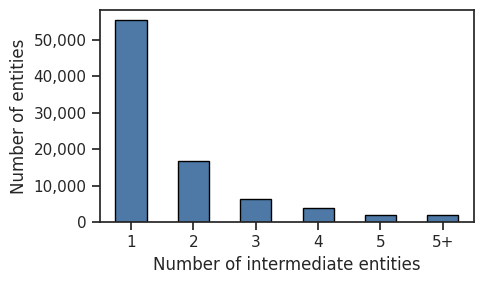

In [14]:
# Calculate the number of occurrences
entities_multiple_entity_owners =  results_df[(results_df['no_of_persons'] == 0) & (results_df['no_of_entities'] > 1)]

# Calculate the value counts
value_counts = entities_multiple_entity_owners['no_of_entities'].value_counts().sort_index()

# Adjust axis with -1 for x-axis adjustment
value_counts_adjusted = value_counts.copy()
value_counts_adjusted.index = value_counts_adjusted.index - 1

# Aggregate categories >5 into a '5+' category
over_5_sum = value_counts_adjusted[value_counts_adjusted.index > 5].sum() 
value_counts_adjusted = value_counts_adjusted[value_counts_adjusted.index <= 5]
value_counts_adjusted.loc['5+'] = over_5_sum

# Plot the bar chart
fig, ax = plt.subplots(figsize=(5, 3))
value_counts_adjusted.plot(kind='bar', ax=ax, color=crayon[0], edgecolor='black')

# Adjust x-axis labels
ax.set_xticks(range(len(value_counts_adjusted)))
ax.set_xticklabels(value_counts_adjusted.index, rotation=0, ha='center')

# Format y-axis with thousand separators
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{int(x):,}'))

# Adding labels
plt.xlabel('Number of intermediate entities')
plt.ylabel('Number of entities')

# Display the plot
plt.tight_layout()
output_path = 'Images/Figure_4.png'
plt.savefig(output_path, dpi=800)
plt.show()

In [15]:
(entities_multiple_entity_owners['no_of_entities']-1).describe().round(0)

count    86468.0
mean         2.0
std          1.0
min          1.0
25%          1.0
50%          1.0
75%          2.0
max         18.0
Name: no_of_entities, dtype: float64

***
## 3. Individual beneficial owners with multiple entity connections

In [16]:
# Filter rows where the interested party is a person (not an entity)
person_interested_parties = merged_ooc[merged_ooc['interestedParty_describedByPersonID'].notna()]

# Group by person ID and count the number of unique subjects (entities)
persons_linked_to_entities = person_interested_parties.groupby('interestedParty_describedByPersonID')['ooc_statementID'].nunique().reset_index(name='unique_entities')

# Filter to get only persons associated with more than one entity
persons_multiple_entities = persons_linked_to_entities[persons_linked_to_entities['unique_entities'] > 1]

# Filter to get only persons associated with one entity
persons_one_entity = persons_linked_to_entities[persons_linked_to_entities['unique_entities'] == 1]

# Calculate the percentage of BOs who own more than one entity
percentage_multiple_entities = (persons_multiple_entities.shape[0] / len_ps) * 100

# Display the count
print(f'Number of individual beneficial owners with interests in multiple entities: {len(persons_multiple_entities):,} ({percentage_multiple_entities:.0f}% out of {len_ps:,})')

Number of individual beneficial owners with interests in multiple entities: 644,405 (12% out of 5,175,041)


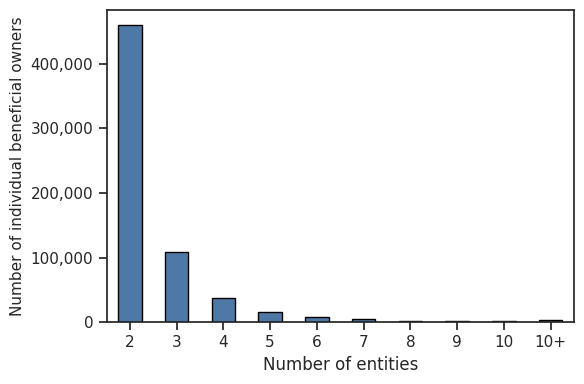

In [17]:
# Calculate the value counts
value_counts = persons_multiple_entities['unique_entities'].value_counts().sort_index()

# Adjust axis with -1 for x-axis adjustment
value_counts_adjusted = value_counts.copy()
#value_counts_adjusted.index = value_counts_adjusted.index - 1  # Apply the -1 adjustment to the index

# Aggregate categories >10 into a '10+' category
over_10_sum = value_counts_adjusted[value_counts_adjusted.index > 10].sum() 
value_counts_adjusted = value_counts_adjusted[value_counts_adjusted.index <= 10]
value_counts_adjusted.loc['10+'] = over_10_sum

# Plot the bar chart
fig, ax = plt.subplots(figsize=(6, 4))
value_counts_adjusted.plot(kind='bar', ax=ax, color=crayon[0], edgecolor='black')

# Adjust x-axis labels
ax.set_xticks(range(len(value_counts_adjusted)))
ax.set_xticklabels(value_counts_adjusted.index, rotation=0, ha='center')

# Format y-axis with thousand separators
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'{int(x):,}'))

# Adding labels
plt.xlabel('Number of entities')
plt.ylabel('Number of individual beneficial owners', fontsize=11)

# Display the plot
plt.tight_layout()
output_path = 'Images/Figure_5.png'
plt.savefig(output_path, dpi=800)
plt.show()

In [18]:
persons_multiple_entities['unique_entities'].describe().round(0)

count    644405.0
mean          3.0
std           4.0
min           2.0
25%           2.0
50%           2.0
75%           3.0
max        1296.0
Name: unique_entities, dtype: float64

In [19]:
# Remove duplicates by person_statementID
unique_persons = merged_person.drop_duplicates(subset='person_ID')

# Get the top 5 persons with the most unique entities, ordered by number of entities owned
top_5_entities = (
    persons_multiple_entities
    .sort_values(by='unique_entities', ascending=False)
    .head(5)
)

# Get their IDs in the order of most entities owned
top_5_entities_ids = top_5_entities['interestedParty_describedByPersonID'].tolist()

# Display merged_person details of those persons, maintaining the order by number of entities owned
top_5_person_details = unique_persons.set_index('person_ID').loc[top_5_entities_ids].reset_index()

# Add the number of entities owned to the display
top_5_person_details = pd.merge(
    top_5_person_details,
    top_5_entities[['interestedParty_describedByPersonID', 'unique_entities']],
    left_on='person_ID',
    right_on='interestedParty_describedByPersonID',
    how='left'
).drop(columns='interestedParty_describedByPersonID').rename(columns={'unique_entities': 'Number of entities'})

# Sort by number of entities owned for display and keep top 5
top_5_person_details = top_5_person_details.sort_values(by='Number of entities', ascending=False).head(5).reset_index(drop=True)
top_5_person_details = top_5_person_details[['person_ID', 'Number of entities']]

# Display the result
top_5_person_details

,person_ID,Number of entities
0,/entities/8929797199686509282,1296
1,/entities/11872741694614117799,1064
2,/entities/13008530788123484216,810
3,/entities/4729462654749175298,665
4,/entities/8466533495566600095,654


***
## 4. Individual beneficial owners with single entity connections

In [20]:
# Identify unique person IDs associated with only one entity
person_one_entity_list = persons_one_entity['interestedParty_describedByPersonID'].tolist()

# Extract relations for these persons from the ownership or control data
person_one_entity_ooc = merged_ooc[merged_ooc['interestedParty_describedByPersonID'].isin(person_one_entity_list)]

# Count the number of unique ownership/control interest types for each ownership/control statement
person_one_entity_interest_type = person_one_entity_ooc.groupby('ooc_statementID')['interest_type'].nunique().reset_index(name='interest_type_count')

# Identify persons that only one ownership/control interest in a single entity
person_one_entity_one_interest = person_one_entity_interest_type[person_one_entity_interest_type['interest_type_count'] == 1]

# Identify persons that have more than one type of interest in a single entity
person_one_entity_multiple_interests = person_one_entity_interest_type[person_one_entity_interest_type['interest_type_count'] > 1]

# Calculate relevant percentages
percentage_persons_one_entity = (len(persons_one_entity) / len_ps) * 100
percentage_persons_one_entity_one_interest = (len(person_one_entity_one_interest) / len(persons_one_entity)) * 100
percentage_persons_one_entity_multiple_interests = (len(person_one_entity_multiple_interests) / len(persons_one_entity)) * 100

# Display the results
print(f'Number of individual beneficial owners of a single entity: {len(persons_one_entity):,} ({percentage_persons_one_entity:.0f}% out of {len_ps:,})')
print(f'Number of individual beneficial owners with a single interest in a single entity: {len(person_one_entity_one_interest):,} ({percentage_persons_one_entity_one_interest:.0f}% out of {len(persons_one_entity):,})')
print(f'Number of individual beneficial owners with multiple interests in a single entity: {len(person_one_entity_multiple_interests):,} 'f'({percentage_persons_one_entity_multiple_interests:.0f}% out of {len(persons_one_entity):,})')

Number of individual beneficial owners of a single entity: 4,530,636 (88% out of 5,175,041)
Number of individual beneficial owners with a single interest in a single entity: 1,385,666 (31% out of 4,530,636)
Number of individual beneficial owners with multiple interests in a single entity: 3,144,970 (69% out of 4,530,636)


### *Individual beneficial owners with a single interest in a single entity*

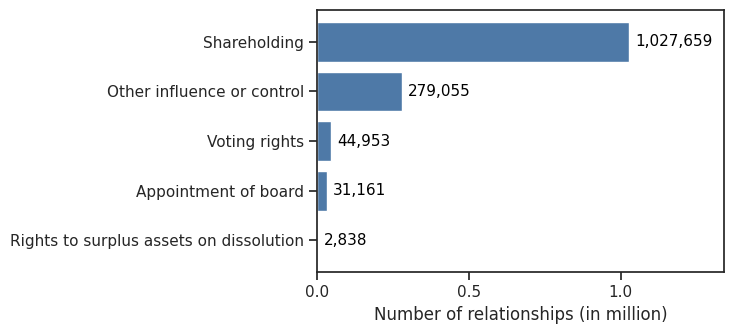

In [21]:
# Filter merged_ooc to include only 'ooc_statementID' that appear in person_one_entity_one_interest
persons_one_entity_one_interest_ooc = merged_ooc[
    merged_ooc['ooc_statementID'].isin(person_one_entity_one_interest['ooc_statementID'])
].reset_index(drop=True)

# Calculate the value counts and sort by frequency in descending order
interest_combinations = persons_one_entity_one_interest_ooc['interest_combination'].value_counts()

# Convert the series to a DataFrame for easier manipulation and sort by frequency
interest_combinations_df = interest_combinations.reset_index()
interest_combinations_df.columns = ['Interest Combination', 'Frequency']
interest_combinations_df = interest_combinations_df.sort_values(by='Frequency', ascending=False)

# Extract frequencies and labels for the bar chart
frequencies = interest_combinations_df['Frequency'].values
labels = interest_combinations_df['Interest Combination'].values

# Plotting a horizontal bar chart
plt.figure(figsize=(7.5, 3.5))
bars = plt.barh(labels, frequencies)

# Adding total frequencies next to the bars
for bar in bars:
    plt.text(
        bar.get_width() + 20_000,
        bar.get_y() + bar.get_height() / 2,
        f'{int(bar.get_width()):,}',
        va='center',
        fontsize=11,
        color='black'
    )

# Adding labels
plt.xlabel('Number of relationships (in million)', fontsize=12)
plt.ylabel('', fontsize=12)

# Format x-axis
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(500_000))
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1_000_000:.1f}'))
plt.gca().set_xlim(0, 1_340_000)

# Invert y-axis to have bars sorted top-to-bottom
plt.gca().invert_yaxis()

# Display the plot
plt.tight_layout()
output_path = 'Images/Figure_6.png'
plt.savefig(output_path, dpi=800)
plt.show()

In [22]:
# Calculate the value counts and percentage
interest_combinations_df = persons_one_entity_one_interest_ooc['interest_combination'].value_counts().reset_index()
interest_combinations_df.columns = ['Interest combination', 'Frequency']
interest_combinations_df['Percentage'] = (interest_combinations_df['Frequency'] / interest_combinations_df['Frequency'].sum()) * 100

# Sort by Frequency in descending order
interest_combinations_df = interest_combinations_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# Format Percentage to two decimal places
interest_combinations_df['Percentage'] = interest_combinations_df['Percentage'].apply(lambda x: f'{x:.0f}%')
interest_combinations_df

,Interest combination,Frequency,Percentage
0,Shareholding,1027659,74%
1,Other influence or control,279055,20%
2,Voting rights,44953,3%
3,Appointment of board,31161,2%
4,Rights to surplus assets on dissolution,2838,0%


In [23]:
# Define the desired order for threshold ranges
desired_order = ['25-50', '50-75', '75-100']

# Filter data for 'Shareholding' and calculate frequencies
shareholding_threshold_counts = persons_one_entity_one_interest_ooc[persons_one_entity_one_interest_ooc['interest_type'] == 'Shareholding']['threshold_range'].value_counts()
shareholding_threshold_percentages = (shareholding_threshold_counts / shareholding_threshold_counts.sum()) * 100

# Combine into a DataFrame for 'Shareholding'
shareholding_table = pd.DataFrame({
    'Count': shareholding_threshold_counts,
    'Percentage': shareholding_threshold_percentages.round(1).astype(str) + '%'
}).reset_index().rename(columns={'threshold_range': 'Shareholding threshold range'})

# Reorder categories according to the desired order
shareholding_table['Shareholding threshold range'] = pd.Categorical(shareholding_table['Shareholding threshold range'], categories=desired_order, ordered=True)
shareholding_table = shareholding_table.sort_values('Shareholding threshold range').reset_index(drop=True)

# Display the results
display(shareholding_table)

# Filter data for 'Voting Rights' and calculate frequencies
voting_rights_threshold_counts = persons_one_entity_one_interest_ooc[persons_one_entity_one_interest_ooc['interest_type'] == 'Voting rights']['threshold_range'].value_counts()
voting_rights_threshold_percentages = (voting_rights_threshold_counts / voting_rights_threshold_counts.sum()) * 100

# Combine into a DataFrame for 'Voting Rights'
voting_rights_table = pd.DataFrame({
    'Count': voting_rights_threshold_counts,
    'Percentage': voting_rights_threshold_percentages.round(1).astype(str) + '%'
}).reset_index().rename(columns={'threshold_range': 'Voting rights threshold range'})

# Reorder categories according to the desired order
voting_rights_table['Voting rights threshold range'] = pd.Categorical(voting_rights_table['Voting rights threshold range'], categories=desired_order, ordered=True)
voting_rights_table = voting_rights_table.sort_values('Voting rights threshold range').reset_index(drop=True)

# Display the results
display(voting_rights_table)

,Shareholding threshold range,Count,Percentage
0,25-50,400025,38.9%
1,50-75,63143,6.1%
2,75-100,564491,54.9%


,Voting rights threshold range,Count,Percentage
0,25-50,35367,78.7%
1,50-75,2078,4.6%
2,75-100,7508,16.7%


### *Individual beneficial owners with multiple interests in a single entity*

In [24]:
# Filter data for persons with multiple interests in a single entity
persons_multiple_interests_ooc = merged_ooc[merged_ooc['ooc_statementID'].isin(person_one_entity_multiple_interests['ooc_statementID'])]

# Identify persons with multiple interests in a single entity
persons_multiple_interests = persons_multiple_interests_ooc.groupby(
    ['interestedParty_describedByPersonID', 'subject_describedByEntityID']
)['interest_type'].nunique().reset_index(name='interest_type_count')

# Filter to get only those with more than one type of interest
persons_with_multiple_interests = persons_multiple_interests[persons_multiple_interests['interest_type_count'] > 1]

# Calculate relevant percentages
percentage_persons_multiple_interests = (len(persons_with_multiple_interests) / len(persons_multiple_interests_ooc['interestedParty_describedByPersonID'].unique())) * 100

# Calculate the number of entities involved
n_entities_multiple_interests = persons_multiple_interests_ooc['subject_describedByEntityID'].nunique()

# Count unique beneficial owners per entity
entities_with_bo_counts = persons_multiple_interests_ooc.groupby('subject_describedByEntityID')['interestedParty_describedByPersonID'].nunique()

# Number of entities with a single beneficial owner having multiple interests
n_entities_with_single_bo_multiple_interests = entities_with_bo_counts[entities_with_bo_counts == 1].count()

# Percentage of entities with a single beneficial owner having multiple interests
percentage_entities_with_single_bo_multiple_interests = (n_entities_with_single_bo_multiple_interests / n_entities_multiple_interests) * 100

# Number of entities and % with more than one beneficial owner, with at least one having multiple interests
n_entities_with_multiple_bos_one_with_multiple_interests = entities_with_bo_counts[entities_with_bo_counts > 1].count()
percentage_entities_with_multiple_bos_one_with_multiple_interests = (n_entities_with_multiple_bos_one_with_multiple_interests / n_entities_multiple_interests) * 100

# Calculate number and percentage of entities with exactly 2 beneficial owners
n_entities_with_two_bos = entities_with_bo_counts[entities_with_bo_counts == 2].count()
percentage_entities_with_two_bos = (n_entities_with_two_bos / n_entities_with_multiple_bos_one_with_multiple_interests) * 100

# Maximum number of BOs in entities with at least one holding multiple interests
# Filter entities with at least one BO holding multiple interests
entities_with_multiple_interests = persons_multiple_interests_ooc['subject_describedByEntityID'].unique()

# Filter merged_ooc for these entities
ooc_multiple_interests = merged_ooc[
    merged_ooc['subject_describedByEntityID'].isin(entities_with_multiple_interests)
]

# Count unique beneficial owners in these entities
entities_with_multiple_bo_counts = ooc_multiple_interests.groupby('subject_describedByEntityID')['interestedParty_describedByID'].nunique()

# Get the maximum number of BOs for entities with at least one holding multiple interests
max_bo_multiple_interests = entities_with_multiple_bo_counts.max()

# Display the results
print(f'Number of individual beneficial owners with multiple interests in a single entity: {len(persons_with_multiple_interests):,}')

Number of individual beneficial owners with multiple interests in a single entity: 3,144,971


In [25]:
# Filter data for persons with multiple interests in a single entity
persons_multiple_interests_ooc = merged_ooc_aggregate[merged_ooc_aggregate['ooc_statementID'].isin(person_one_entity_multiple_interests['ooc_statementID'])]

# Calculate the value counts and percentage for interest combinations
interest_combinations_df = persons_multiple_interests_ooc['interest_combination'].value_counts().reset_index()
interest_combinations_df.columns = ['Interest combination', 'Frequency']
interest_combinations_df['Percentage'] = (interest_combinations_df['Frequency'] / interest_combinations_df['Frequency'].sum()) * 100

# Sort by Frequency in descending order
interest_combinations_df = interest_combinations_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

# Format Percentage to two decimal places
interest_combinations_df['Percentage'] = interest_combinations_df['Percentage'].apply(lambda x: f'{x:.0f}%')

# Display table
interest_combinations_df.head()

,Interest combination,Frequency,Percentage
0,Appointment of board - Shareholding - Voting r...,2081395,66%
1,Shareholding - Voting rights,885877,28%
2,Appointment of board - Other influence or cont...,78640,3%
3,Appointment of board - Voting rights,28841,1%
4,Appointment of board - Shareholding,18455,1%


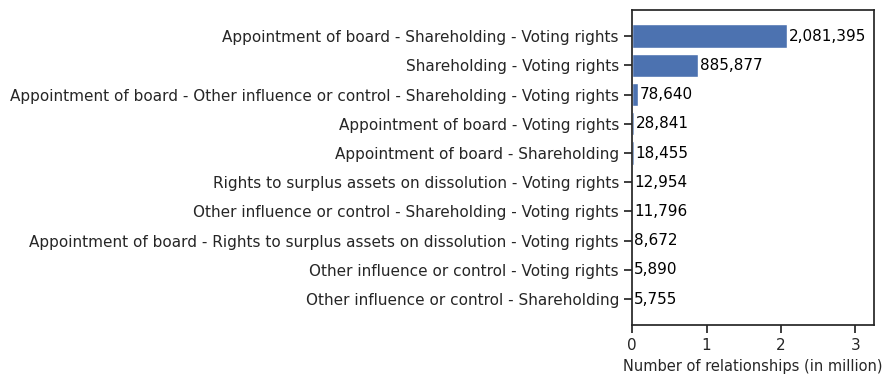

In [26]:
# Select the top 10 frequencies
top_10_df = interest_combinations_df.head(10)

# Extract frequencies and labels for the bar chart
frequencies = top_10_df['Frequency'].values
labels = top_10_df['Interest combination'].values

# Plotting a horizontal bar chart
plt.figure(figsize=(9, 4))
bars = plt.barh(labels, frequencies, color='#4C72B0')

# Adding total frequencies next to the bars
for bar in bars:
    plt.text(
        bar.get_width() + 20_000,
        bar.get_y() + bar.get_height() / 2,
        f'{int(bar.get_width()):,}',
        va='center',
        fontsize=11,
        color='black'
    )

# Adding labels
plt.xlabel('Number of relationships (in million)', fontsize=10.5)
plt.ylabel('', fontsize=12)

# Format x-axis
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1_000_000))
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1_000_000:.0f}'))
plt.gca().set_xlim(0, 3_250_000)

# Invert y-axis to have bars sorted top-to-bottom
plt.gca().invert_yaxis()

# Display the plot
plt.tight_layout()
output_path = 'Images/Figure_7.png'
plt.savefig(output_path, dpi=800)
plt.show()

In [27]:
# Calculate the cross-tabulation with counts
cross_tab_counts = pd.crosstab(
    persons_multiple_interests_ooc['shareholding_range'], 
    persons_multiple_interests_ooc['voting_rights_range']
)

# Calculate the cross-tabulation with percentages
cross_tab_percentages = (cross_tab_counts / cross_tab_counts.sum().sum()) * 100

# Combine counts and percentages into one DataFrame
cross_tab_combined = cross_tab_counts.astype(str) + " (" + cross_tab_percentages.round(0).astype(int).astype(str) + "%)"

# Display the combined table
display(cross_tab_combined)

voting_rights_range,25-50,50-75,75-100
shareholding_range,,,
25-50,1172544 (38%),0 (0%),0 (0%)
50-75,0 (0%),129737 (4%),0 (0%)
75-100,0 (0%),0 (0%),1755427 (57%)


***
## 5. Entities with at least one individual beneficial owner holding multiple interests*

In [28]:
# Display the results
print(f'Number of individual beneficial owners with multiple interests in a single entity: {len(persons_with_multiple_interests):,}')
percentage_entities_with_bos_multiple_interests = (n_entities_multiple_interests / total_entities) * 100
print(f'Number of entities with beneficial owners holding multiple interests: {n_entities_multiple_interests:,} out of {total_entities:,} ({percentage_entities_with_bos_multiple_interests:.0f}%)')
print(f'Number of entities with a single beneficial owner having multiple interests: {n_entities_with_single_bo_multiple_interests:,} ({percentage_entities_with_single_bo_multiple_interests:.0f}%)')
print(f'Number of entities with more than one beneficial owner, with at least one having multiple interests: {n_entities_with_multiple_bos_one_with_multiple_interests:,} ({percentage_entities_with_multiple_bos_one_with_multiple_interests:.0f}%)')
print(f'Number of entities with exactly 2 beneficial owners: {n_entities_with_two_bos:,} ({percentage_entities_with_two_bos:.0f}%)')
print(f'Maximum number of beneficial owners in a single entity with at least one holding multiple interests: {max_bo_multiple_interests:,}')

Number of individual beneficial owners with multiple interests in a single entity: 3,144,971
Number of entities with beneficial owners holding multiple interests: 2,593,157 out of 6,061,128 (43%)
Number of entities with a single beneficial owner having multiple interests: 2,080,284 (80%)
Number of entities with more than one beneficial owner, with at least one having multiple interests: 512,873 (20%)
Number of entities with exactly 2 beneficial owners: 477,344 (93%)
Maximum number of beneficial owners in a single entity with at least one holding multiple interests: 41


In [29]:
# Identify the entity with the maximum number of BOs
entity_max_bo_multiple_interests = entities_with_multiple_bo_counts.idxmax()

# Retrieve OOC data for this entity
ooc_max_bo_multiple_interests = merged_ooc[
    merged_ooc['subject_describedByEntityID'] == entity_max_bo_multiple_interests
]

# Merge person names into the OOC data
ooc_max_bo_multiple_interests = ooc_max_bo_multiple_interests.merge(
    merged_person[['person_ID', 'person_fullName']],
    left_on='interestedParty_describedByPersonID',
    right_on='person_ID',
    how='left'
)

# Merge entity names into the OOC data
ooc_max_bo_multiple_interests = ooc_max_bo_multiple_interests.merge(
    merged_entity[['entity_ID', 'entity_name']],
    left_on='subject_describedByEntityID',
    right_on='entity_ID',
    how='left'
)

# Select relevant columns
ooc_max_bo_multiple_interests_display = ooc_max_bo_multiple_interests[[
    'ooc_statementID',
    'person_fullName',
    'entity_name',
    'interest_combination',
    'interest_type',
    'threshold_range'
]]

# Drop duplicates based on key columns while keeping the first occurrence
ooc_max_bo_multiple_interests_display = ooc_max_bo_multiple_interests_display.drop_duplicates().reset_index(drop=True)

# Display the results
ooc_max_bo_multiple_interests_display['person_fullName'].nunique()

41

In [30]:
ooc_max_bo_multiple_interests_display['interest_combination'].value_counts()

interest_combination
Appointment of board - Voting rights    82
Name: count, dtype: int64

In [31]:
pd.crosstab(ooc_max_bo_multiple_interests_display['interest_type'], ooc_max_bo_multiple_interests_display['threshold_range'])

threshold_range,25-50
interest_type,
Voting rights,41


### *Entities with two beneficial owners, one holding multiple interests*

In [32]:
# Filter for entities with exactly two beneficial owners
entities_with_two_bos = entities_with_bo_counts[entities_with_bo_counts == 2].index

# Subset merged_ooc for these entities
two_bos_ooc = merged_ooc[
    merged_ooc['subject_describedByEntityID'].isin(entities_with_two_bos)
].reset_index(drop=True)

# Count unique interest combinations per entity
interest_counts_per_entity = two_bos_ooc.groupby('subject_describedByEntityID')['interest_combination'].nunique()

# Identify entities where both beneficial owners have the exact same interest type(s)
entities_with_same_interest = interest_counts_per_entity[interest_counts_per_entity == 1].index

# Filter for ownership/control relations involving these entities
relations_with_same_interest = two_bos_ooc[two_bos_ooc['subject_describedByEntityID'].isin(entities_with_same_interest)]

# Count the number of such relationships
n_relations_with_same_interest = len(relations_with_same_interest)

# Calculate percentage of entities with exactly two BOs having the same interest
percentage_same_interest = (len(entities_with_same_interest) / len(entities_with_two_bos)) * 100

# Display the updated statistics
print(f'Number of entities with exactly two beneficial owners: {len(entities_with_two_bos):,}')
print(f'Number of such entities where beneficial owners have the same types of interests: {len(entities_with_same_interest):,} ({percentage_same_interest:.0f}%)')

Number of entities with exactly two beneficial owners: 477,344
Number of such entities where beneficial owners have the same types of interests: 397,063 (83%)


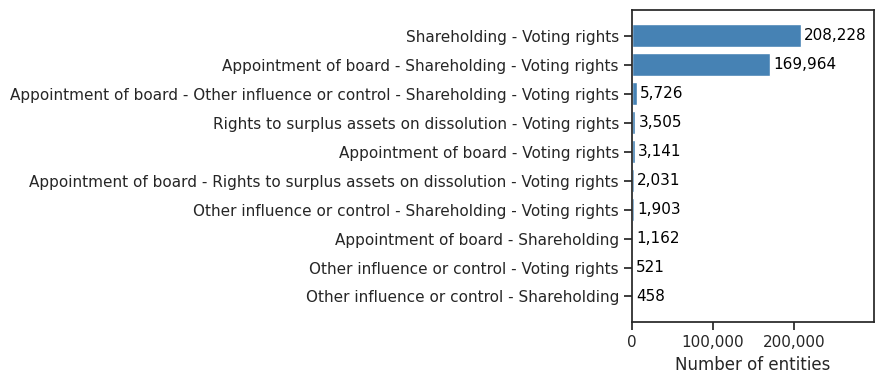

In [33]:
# Aggregate interest type combinations by entity
entity_interest_frequencies = (
    relations_with_same_interest.groupby('subject_describedByEntityID')['interest_combination']
    .first()  # Get one interest combination per entity
    .value_counts()
    .reset_index()
    .rename(columns={'interest_combination': 'Interest combination', 'count': 'Frequency'})
)

# Extract top 10 values for plotting
top_10_interest_combinations = entity_interest_frequencies.head(10).sort_values(by='Frequency', ascending=False)

# Plot graph
plt.figure(figsize=(9, 4))
bars = plt.barh(
    top_10_interest_combinations['Interest combination'], 
    top_10_interest_combinations['Frequency'], 
    color='steelblue'
)

# Add frequency labels next to the bars
for bar in bars:
    plt.text(
        bar.get_width() + 0.02 * max(top_10_interest_combinations['Frequency']),
        bar.get_y() + bar.get_height() / 2,
        f'{int(bar.get_width()):,}', 
        va='center',
        fontsize=11,
        color='black'
    )

# Adding labels
plt.xlabel('Number of entities', fontsize=12)
plt.ylabel('')

# Format x-axis
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(100_000))
plt.gca().set_xlim(0, 299_000)

# Invert y-axis to have bars sorted top-to-bottom
plt.gca().invert_yaxis()

# Display the plot
plt.tight_layout()
output_path = 'Images/Figure_8.png'
plt.savefig(output_path, dpi=800)
plt.show()

In [34]:
# Add a percentage column to the existing DataFrame
entity_interest_frequencies['Percentage'] = (
    (entity_interest_frequencies['Frequency'] / entity_interest_frequencies['Frequency'].sum()) * 100
).round(0).astype(int).astype(str) + '%'

# Display the updated DataFrame with percentages
entity_interest_frequencies.head()

,Interest combination,Frequency,Percentage
0,Shareholding - Voting rights,208228,52%
1,Appointment of board - Shareholding - Voting r...,169964,43%
2,Appointment of board - Other influence or cont...,5726,1%
3,Rights to surplus assets on dissolution - Voti...,3505,1%
4,Appointment of board - Voting rights,3141,1%


In [35]:
# Calculate the sum of the first three cases' frequencies
sum_first_three = top_10_interest_combinations['Frequency'].iloc[0:3].sum()

# Print the result with a clear message
print(f"Number of entities involved in the first three cases: {sum_first_three:,}")

Number of entities involved in the first three cases: 383,918


In [36]:
# Get the top 3 interest combinations
top_3_combinations = entity_interest_frequencies.head(3)['Interest combination'].tolist()

# Initialize a dictionary to store tables for each of the top 3 combinations
top_3_entity_tables = {}

# Loop through each of the top 3 combinations
for combination in top_3_combinations:
    # Filter entities with the current interest combination
    entities_with_combination = relations_with_same_interest[
        relations_with_same_interest['interest_combination'] == combination
    ]['subject_describedByEntityID'].unique()

    # Filter merged_ooc for relationships of these entities
    relevant_relationships = merged_ooc[
        merged_ooc['subject_describedByEntityID'].isin(entities_with_combination)
    ]

    # Get unique entities for the combination
    n_entities = len(entities_with_combination)
    
    # Calculate Shareholding threshold frequencies by entity
    shareholding_entities = relevant_relationships[
        relevant_relationships['interest_type'] == 'Shareholding'
    ].groupby('subject_describedByEntityID')['threshold_range'].first().value_counts().reindex(desired_order).fillna(0).astype(int)
    shareholding_entities_percent = (shareholding_entities / n_entities) * 100

    # Combine into a DataFrame for 'Shareholding'
    shareholding_table = pd.DataFrame({
        'Count': shareholding_entities,
        'Percentage': shareholding_entities_percent.round(1).astype(str) + '%'
    }).reset_index().rename(columns={'index': 'Shareholding threshold range'})

    # Calculate Voting Rights threshold frequencies by entity
    voting_rights_entities = relevant_relationships[
        relevant_relationships['interest_type'] == 'Voting rights'
    ].groupby('subject_describedByEntityID')['threshold_range'].first().value_counts().reindex(desired_order).fillna(0).astype(int)
    voting_rights_entities_percent = (voting_rights_entities / n_entities) * 100

    # Combine into a DataFrame for 'Voting Rights'
    voting_rights_table = pd.DataFrame({
        'Count': voting_rights_entities,
        'Percentage': voting_rights_entities_percent.round(1).astype(str) + '%'
    }).reset_index().rename(columns={'index': 'Voting rights threshold range'})

    # Store the tables in the dictionary
    top_3_entity_tables[combination] = {
        'Entities involved': n_entities,
        'Shareholding': shareholding_table,
        'Voting rights': voting_rights_table
    }

# Display the tables
for combination, tables in top_3_entity_tables.items():
    print(f"\nInterest Combination: {combination}")
    print(f"Number of entities involved: {tables['Entities involved']:,}")
    print("\nShareholding thresholds:")
    display(tables['Shareholding'])
    print("\nVoting rights thresholds:")
    display(tables['Voting rights'])


Interest Combination: Shareholding - Voting rights
Number of entities involved: 208,228

Shareholding thresholds:


,threshold_range,Count,Percentage
0,25-50,195308,93.8%
1,50-75,10312,5.0%
2,75-100,2608,1.3%



Voting rights thresholds:


,threshold_range,Count,Percentage
0,25-50,195263,93.8%
1,50-75,10313,5.0%
2,75-100,2652,1.3%



Interest Combination: Appointment of board - Shareholding - Voting rights
Number of entities involved: 169,964

Shareholding thresholds:


,threshold_range,Count,Percentage
0,25-50,151961,89.4%
1,50-75,8578,5.0%
2,75-100,9425,5.5%



Voting rights thresholds:


,threshold_range,Count,Percentage
0,25-50,151817,89.3%
1,50-75,8587,5.1%
2,75-100,9560,5.6%



Interest Combination: Appointment of board - Other influence or control - Shareholding - Voting rights
Number of entities involved: 5,726

Shareholding thresholds:


,threshold_range,Count,Percentage
0,25-50,4870,85.1%
1,50-75,548,9.6%
2,75-100,308,5.4%



Voting rights thresholds:


,threshold_range,Count,Percentage
0,25-50,4863,84.9%
1,50-75,545,9.5%
2,75-100,317,5.5%


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=27c07745-1165-42be-9ff2-15a6438f3717' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>